In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import seaborn as sns
import statsmodels.api as sm

from collections import defaultdict

In [2]:

#read in the data from the files
file_dir = '/Users/zihaoxu/Desktop/Pomona/2017_Spring/Data Science Research/yz_data/' #replace this with the path to your data files

f = {'R': 'R_review_stat.csv', 'T': 'T_review_text.csv', 'N': 'N_neighborhood.csv',\
    'B': 'B_business.csv', 'U': 'U_user.csv','E':'E_rent.csv'}

d = defaultdict() #initialize an empty dictionary to hold the dataframes

for fi in f: #for each file in the dictinary of files
    d[fi] = pd.read_csv(file_dir + f[fi]) #read in the files and hold them in the dataframe dictionary
d['E'] = pd.DataFrame(d['E'])

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# newDf = d['E'].iloc[:,:6]

# dataDf respresents the part of data frame that only contains rent data
dataDf = d['E'].iloc[:,7:]

In [15]:
# converting column names to decimals
times = list()
for date in list(dataDf.columns)[:]:
    temp = 4
    s = 0
    for i in date:
        if temp > 0:
            s = s + int(i) * 10 ** (temp-1)
        if temp == -1:
            s = s + int(i)*10./12.
        if temp == -2:
            s = s + int(i)/12.
        temp = temp -1
    times.append(s)

In [17]:
# a function that convert a cell in dataFrame to 1 if it is not NaN
def toOne(df):
    result = df.copy()
    for i in range(len(df)):
        for j in range(len(df.iloc[0,:])):
            if np.isnan(result.iloc[i,j]):
                result.iloc[i,j] = 0.
            else:
                result.iloc[i,j] = 1.
    return result

def toColname(df):
    result = df.copy()
    for i in range(len(df)):
        for j in range(len(df.iloc[0,:])):
            if not np.isnan(result.iloc[i,j]):
                result.iloc[i,j] = times[j]
            
    return result
def calculateSpan(df):
    result = []
    for i in range(len(df)):
        s = np.nanmax(df.iloc[i,:])[0] - np.nanmin(df.iloc[i,:])[0]
        result.append(s)
    return result

In [18]:
i = toColname(dataDf)

In [19]:
allYears = []

for r in range(len(i)):
    for j in range(len(i.iloc[0,:])):
        allYears.append(i.iloc[r,j])
allYears = pd.Series(allYears).dropna()

# Result 1: Histogram for distributions of years

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


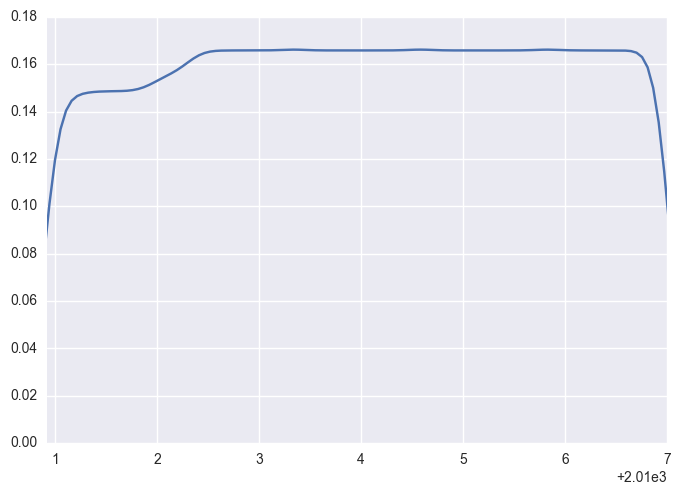

In [20]:
sns.distplot(allYears, hist = False)
plt.xlim(2010+11/12,2017)
plt.show()

# Result 2: number of entries that each row (neighborhood) has

In [21]:
# look at the summary of results: number of entries that each row (neighborhood) has
countsDf = toOne(dataDf)
countsDf['counts'] = countsDf.sum(axis = 1)
countsDf['counts'].describe()

count    6589.000000
mean       72.331158
std         4.773679
min        57.000000
25%        74.000000
50%        74.000000
75%        74.000000
max        74.000000
Name: counts, dtype: float64

# Result 3: Histogram of time span for every neighborhoods

In [22]:
result = pd.Series(calculateSpan(i))
        

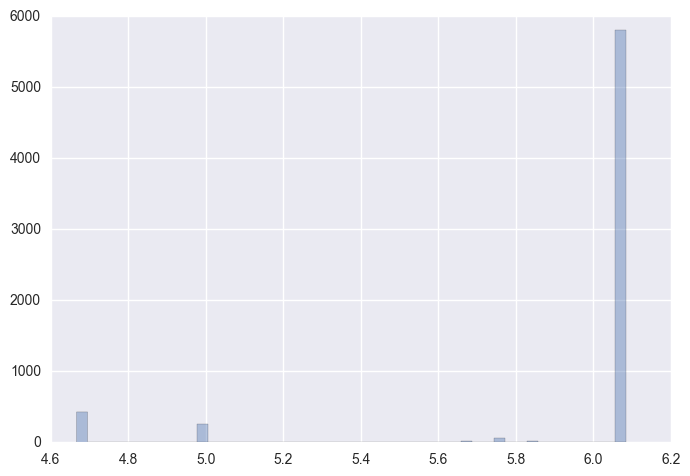

In [23]:
# Distribution of the timespan for each neighborhood

sns.distplot(result,kde = False)
plt.show()

# Creating the csv for rents

In [24]:
transposed = d['E'].transpose()

rent_time_series = transposed.drop(transposed.index[1:7])
rent_time_series.columns = rent_time_series.iloc[0]
rent_time_series = rent_time_series.drop(rent_time_series.index[0])
rent_time_series['year'] = times
# rent_time_series.iloc[:, len(rent_time_series)] = 0


In [25]:
rent_csv = defaultdict(list)

for ids in list(rent_time_series):
    
    wls = sm.WLS(rent_time_series[ids].astype(float), sm.add_constant(rent_time_series['year'])).fit()
    rent_csv['rent_slope'].append(wls.params['year'])
    rent_csv['rent_p_value'].append(wls.pvalues['year'])
    rent_csv['rent_err'].append(wls.bse['year'])
    rent_csv['z_hood'].append(ids)


In [26]:
rent_csv = pd.DataFrame(rent_csv).dropna()
rent_csv.to_csv('/Users/zihaoxu/Desktop/rent_csv.csv')
print (rent_csv.head())

   rent_err  rent_p_value  rent_slope  z_hood
0  2.766150  4.017588e-41   79.310715  274772
1  1.431948  1.351650e-14   13.805731  192689
2  2.077558  1.265554e-20   27.076194  112345
4  7.838746  2.469134e-30  152.196076   27080
5  5.114134  3.629726e-28   91.342703  118208


In [487]:
def InCategory(string_list, string):
    if string in string_list:
        out = 1
    else:
        out = 0
    return out

In [523]:
kwList = ['Restaurants', 'Shopping', 'Food', 'Beauty & Spas', 'Health & Medical', 'NightLife', 'Home Services', \
          'Bars', 'Automotive', 'Local Services', 'Active Life', 'Fashion', 'Event Planning & Services', 'Fast Food'\
         'Pizza','Mexican', 'Hotels & Travel', 'American (Traditional)', 'Sandwishes', 'Arts & Entertainment']

d['RB'] = pd.merge(d['R'],d['B'][['business_id', 'categories']], on = 'business_id') #adding categories to review dataframe

for kw in kwList:
    for zHood in list(rent_time_series):
        d['RB'][kw] = d['RB']['categories'].apply(InCategory, args = (kw,)) #if kw in categories, then append 1.
        d['CRB'] = d['RB'][d['RB'][kw] == 1] #category dataframe: all rows in the category

        r = d['CRB'][d['CRB']['z_hood'] == zHood]
        rent_csv[kw+'_mean'].append(np.mean(r['stars']))
        try:
            # perform the WLS
            wls = sm.WLS(r['stars'], sm.add_constant(r['year'])).fit()
            rent_csv[kw + '_slope'].append(wls.params['year'])
            rent_csv[kw + '_err'].append(wls.bse['year'])
        except Exception as e:
            print (e)
            rent_csv[kw + '_slope'].append(np.nan)
            rent_csv[kw + '_err'].append(np.nan)
    
    
    

zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction operation maximum which has no identity
zero-size array to reduction opera

/Users/zihaoxu/anaconda/lib/python3.5/site-packages/pandas/core/ops.py:716: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

In [526]:
print (rent_csv)

defaultdict(<class 'list'>, {'Restaurants_err': [0.015822432394084103, 0.0046442366532311666, 0.0056038753411194967, 0.0052093590349832301, 0.002676036402788871, 0.0051626358145358984, 0.0034223979228767644, 0.0086574415072816803, 0.0024862189471107632, 0.0068167777540811356, 0.030524065312971315, 0.0035699182285250279, 0.010993988679448811, 0.003208719018968134, 0.014122960702281166, 0.010852472612493547, 0.01495586118955153, nan, nan, 0.015822432394084103, nan, nan, nan, nan, nan, nan, nan, nan, 0.0046442366532311666, 0.0056038753411194967, nan, nan, nan, 0.0052093590349832301, nan, nan, nan, nan, nan, 0.002676036402788871, 0.0051626358145358984, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0034223979228767644, nan, nan, nan, 0.0086574415072816803, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0024862189471107632, nan, nan, nan, nan, nan, 0.0068167777540811356, nan, nan, nan, nan, nan, n

In [ ]:
for c in rent_time_series.columns[:5]:
    print (c)
    plt.figure()
    plt.plot(rent_time_series['year'],rent_time_series[c])
    plt.xlim(2010,2016)
    
plt.show()